# Procesamiento de Imagen y Señales MIA-B
# Entrega ejercicio práctico clase 1 - Grupo 7

**Fecha:** 2026-02-10 
**Versión:** 1.0

## Descripción
El presente documento tiene por objetivo presentar la tarea corespondencia a la semana 2

## Objetivos

 - Al audio correspondiente a su voz con ruido blanco, realice una comparación entre filtros IIR y FIR para encontrar al mejor filtro pasa banda. Consulte alguna métrica que le permita tomar la decisión. Debe al menos probar 4 filtros diferentes de los dos tipos.
- Realice una consulta sobre las frecuencias principales de una guitarra y una batería correspondientes a la canción adjuntada en clase y realice un filtro pasa altos para eliminar a la batería y un pasa banda para la guitarra. 

# Actividad 1:

## Importación de Librerías


In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import find_peaks, butter, sosfiltfilt
#Librerias para obtener el path de un archivo
from tkinter import Tk
from tkinter.filedialog import askopenfilename


## Variables Globales

In [2]:
audio_path = r"C:/Users/cyanezru/Downloads/Idles.wav"
audio_out_hpf = "sin-bateria.wav"
audio_out_gtr = "sin-guitarra.wav"
sr_target = 44100               # Frecuencia de muestreo objetivo (opcional)
n_fft = 4096                    # Mayor resolución en frecuencia
hop_length = 512
top_k_peaks = 10                # Cuántos picos principales listar

## Actividad 2:

### Consultar sobre las frecuencias principales de una guitarra y una batería correspondientes a la canción


=== Guitarra (componente armónica): picos dominantes ===
      75.4 Hz (amplitud: 96.79)
     161.5 Hz (amplitud: 33.96)
     204.6 Hz (amplitud: 26.99)
     247.6 Hz (amplitud: 21.30)
     506.0 Hz (amplitud: 20.46)
     753.7 Hz (amplitud: 14.55)
     667.5 Hz (amplitud: 12.84)
    1012.1 Hz (amplitud: 11.16)
     333.8 Hz (amplitud: 11.11)
    2024.1 Hz (amplitud: 10.61)

=== Batería (componente percusiva): picos dominantes ===
      53.8 Hz (amplitud: 20.12)
     161.5 Hz (amplitud: 14.39)
     129.2 Hz (amplitud: 14.15)
     204.6 Hz (amplitud: 13.56)
     247.6 Hz (amplitud: 11.75)
     333.8 Hz (amplitud: 9.60)
     290.7 Hz (amplitud: 8.63)
     506.0 Hz (amplitud: 7.74)
     452.2 Hz (amplitud: 7.04)
     409.1 Hz (amplitud: 7.00)

Estimación aprox. de F0 (mediana) para guitarra: 83.8 Hz


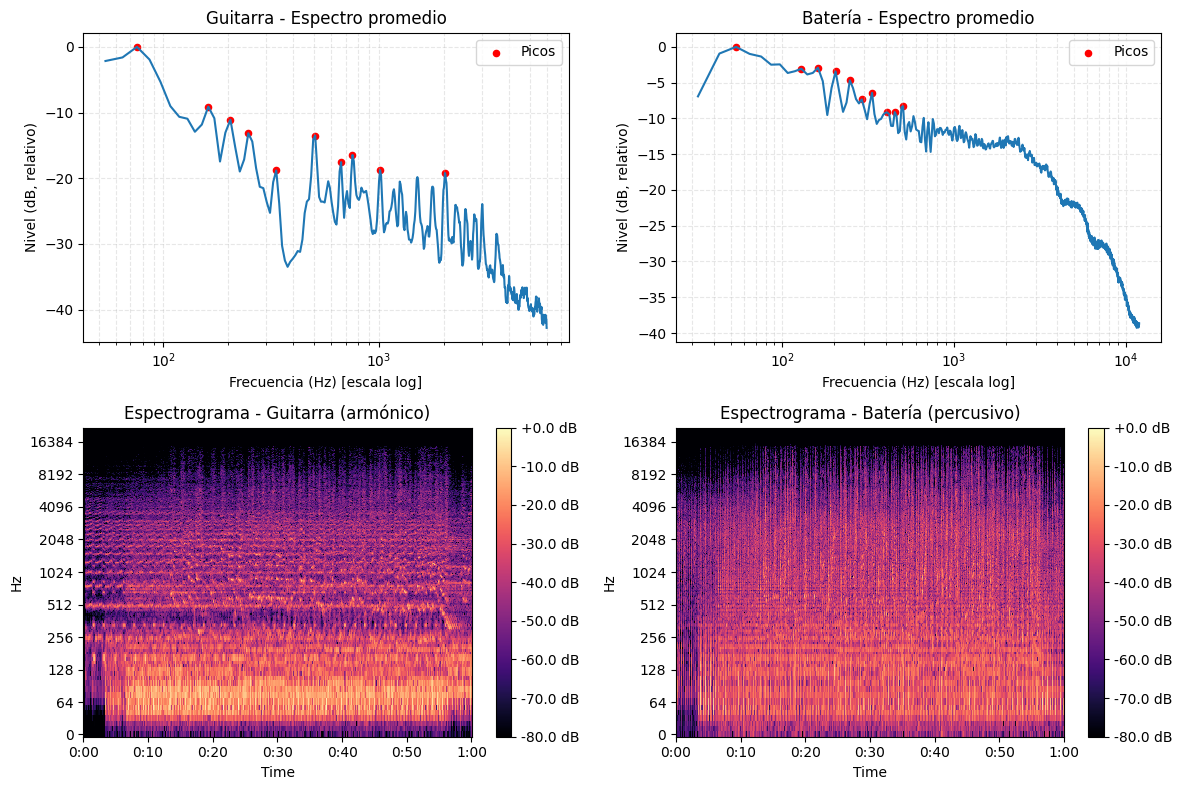

In [3]:
# === 1) Cargar audio en mono ===
y, sr = librosa.load(audio_path, sr=sr_target, mono=True)

# === 2) Separación armónica vs percusiva (HPSS) ===
# Usamos un STFT para HPSS (librosa lo hace internamente)
H, P = librosa.effects.hpss(y, margin=(1.0, 1.0))  # H: armónico (guitarra), P: percusivo (batería)

# === 3) Funciones auxiliares ===
def stft_mag_db(sig, sr, n_fft=4096, hop_length=512):
    S = librosa.stft(sig, n_fft=n_fft, hop_length=hop_length, window="hann", center=True)
    S_mag = np.abs(S)
    S_db = librosa.amplitude_to_db(S_mag, ref=np.max)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    return S_mag, S_db, freqs

def find_main_peaks_average_spectrum(sig, sr, n_fft=4096, hop_length=512, top_k=10, min_freq=30, max_freq=None):
    """
    Calcula el espectro promedio a lo largo del tiempo y detecta picos dominantes.
    Filtra por rango de frecuencia útil. Devuelve (freqs_picos, amplitudes).
    """
    S_mag, _, freqs = stft_mag_db(sig, sr, n_fft=n_fft, hop_length=hop_length)
    # Espectro promedio (media en el eje tiempo)
    mean_spec = S_mag.mean(axis=1)

    # Filtrar rango de interés
    if max_freq is None:
        max_freq = sr / 2
    mask = (freqs >= min_freq) & (freqs <= max_freq)
    freqs_f = freqs[mask]
    spec_f = mean_spec[mask]

    # Encontrar picos (ajusta altura y distancia según sea necesario)
    # distance controla separación mínima entre picos (en bins), rel_height/height para prominencia
    peaks, _ = find_peaks(spec_f, distance=3, prominence=np.max(spec_f) * 0.02)

    # Ordenar picos por amplitud y tomar los top_k
    peak_vals = spec_f[peaks]
    order = np.argsort(peak_vals)[::-1][:top_k]
    top_peaks_idx = peaks[order]
    return freqs_f[top_peaks_idx], spec_f[top_peaks_idx], freqs_f, spec_f

def print_peaks(title, freqs, amps):
    print(f"\n=== {title}: picos dominantes ===")
    for f, a in zip(freqs, amps):
        print(f"  {f:8.1f} Hz (amplitud: {a:.2f})")

# === 4) Analizar guitarra (armónico) ===
guitar_peaks_freqs, guitar_peaks_amps, guitar_freqs, guitar_spec = find_main_peaks_average_spectrum(
    H, sr, n_fft=n_fft, hop_length=hop_length, top_k=top_k_peaks, min_freq=50, max_freq=6000
)

# === 5) Analizar batería (percusivo) ===
drums_peaks_freqs, drums_peaks_amps, drums_freqs, drums_spec = find_main_peaks_average_spectrum(
    P, sr, n_fft=n_fft, hop_length=hop_length, top_k=top_k_peaks, min_freq=30, max_freq=12000
)

# === 6) Reporte de picos ===
print_peaks("Guitarra (componente armónica)", guitar_peaks_freqs, guitar_peaks_amps)
print_peaks("Batería (componente percusiva)", drums_peaks_freqs, drums_peaks_amps)

# === 7) (Opcional) Estimar fundamental de guitarra con YIN/pyin ===
# Esto intenta seguir la fundamental (F0) a lo largo del tiempo; útil si hay notas claras.
f0, voiced_flag, voiced_probs = librosa.pyin(H, fmin=librosa.note_to_hz("E2"), fmax=librosa.note_to_hz("E6"))
f0_median = np.nanmedian(f0)
print(f"\nEstimación aprox. de F0 (mediana) para guitarra: {f0_median:.1f} Hz" if not np.isnan(f0_median) else
      "\nNo se pudo estimar una F0 estable para guitarra (prueba con otro rango o señal más aislada).")

# === 8) (Opcional) Visualizaciones ===
plt.figure(figsize=(12, 8))

# Espectro promedio guitarra
plt.subplot(2, 2, 1)
plt.title("Guitarra - Espectro promedio")
plt.semilogx(guitar_freqs, 20*np.log10(guitar_spec/np.max(guitar_spec)+1e-12))
plt.scatter(guitar_peaks_freqs, 20*np.log10(guitar_peaks_amps/np.max(guitar_spec)+1e-12), color='r', s=20, label="Picos")
plt.xlabel("Frecuencia (Hz) [escala log]")
plt.ylabel("Nivel (dB, relativo)")
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.legend()

# Espectro promedio batería
plt.subplot(2, 2, 2)
plt.title("Batería - Espectro promedio")
plt.semilogx(drums_freqs, 20*np.log10(drums_spec/np.max(drums_spec)+1e-12))
plt.scatter(drums_peaks_freqs, 20*np.log10(drums_peaks_amps/np.max(drums_spec)+1e-12), color='r', s=20, label="Picos")
plt.xlabel("Frecuencia (Hz) [escala log]")
plt.ylabel("Nivel (dB, relativo)")
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.legend()

# Espectrograma armónico
plt.subplot(2, 2, 3)
S_h_db = librosa.amplitude_to_db(np.abs(librosa.stft(H, n_fft=n_fft, hop_length=hop_length)), ref=np.max)
librosa.display.specshow(S_h_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.title("Espectrograma - Guitarra (armónico)")
plt.colorbar(format="%+0.1f dB")

# Espectrograma percusivo
plt.subplot(2, 2, 4)
S_p_db = librosa.amplitude_to_db(np.abs(librosa.stft(P, n_fft=n_fft, hop_length=hop_length)), ref=np.max)
librosa.display.specshow(S_p_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.title("Espectrograma - Batería (percusivo)")
plt.colorbar(format="%+0.1f dB")

plt.tight_layout()
plt.show()

### Realizar un filtro pasa altos para eliminar a la batería y un pasa banda para la guitarra. 

In [4]:
def butter_sos_highpass(fc_hz, fs, order=6):
    """
    Filtro pasa-altos en formato SOS.
    fc_hz: frecuencia de corte (Hz)
    fs: frecuencia de muestreo (Hz)
    """
    nyq = 0.5 * fs
    wn = fc_hz / nyq
    wn = min(max(wn, 1e-6), 0.999999)  # evitar valores inválidos
    sos = butter(order, wn, btype="highpass", output="sos")
    return sos

def butter_sos_bandpass(f1_hz, f2_hz, fs, order=6):
    """
    Filtro pasa-banda Butterworth en formato SOS.
    f1_hz: corte inferior (Hz)
    f2_hz: corte superior (Hz)
    """
    assert f2_hz > f1_hz, "f2_hz debe ser mayor que f1_hz"
    nyq = 0.5 * fs
    w1, w2 = f1_hz / nyq, f2_hz / nyq
    w1 = min(max(w1, 1e-6), 0.98)
    w2 = min(max(w2, 1e-6), 0.999999)
    if w2 <= w1:
        w2 = min(0.999999, w1 + 1e-4)
    sos = butter(order, [w1, w2], btype="bandpass", output="sos")
    return sos

def apply_zero_phase_filter(y, sos):
    """
    Aplica filtrado de fase cero (sosfiltfilt) canal por canal.
    Soporta mono o estéreo (o más canales).
    """
    if y.ndim == 1:
        return sosfiltfilt(sos, y).astype(np.float32)
    else:
        y_out = np.zeros_like(y, dtype=np.float32)
        for ch in range(y.shape[1]):
            y_out[:, ch] = sosfiltfilt(sos, y[:, ch]).astype(np.float32)
        return y_out

# Cortes sugeridos (ajústalos a tu material)
fc_hpf = 180.0        # HPF para atenuar batería (bombo/cuerpo caja). Prueba 150–220 Hz.
f1_bpf, f2_bpf = 80.0, 1200.0  # BPF para guitarra. Puedes ampliar a 5000 Hz si quieres más brillo.
order = 6             # Orden del filtro. 4–8 suele ir bien.

# =========================
# 1) Cargar audio
# =========================
y, fs = sf.read(audio_path, always_2d=False)  # y: (num_muestras,) o (num_muestras, canales)

# Asegurar tipo flotante
y = y.astype(np.float32)

# =========================
# 2) Diseñar filtros
# =========================
sos_hpf = butter_sos_highpass(fc_hpf, fs, order=order)
sos_bpf = butter_sos_bandpass(f1_bpf, f2_bpf, fs, order=order)

# =========================
# 3) Filtrar
# =========================
y_hpf = apply_zero_phase_filter(y, sos_hpf)  # mezcla con batería atenuada
y_gtr = apply_zero_phase_filter(y, sos_bpf)  # banda típica de guitarra

# =========================
# 4) Normalizar suave y guardar
# =========================
def normalize_peak(y, peak_target=0.98):
    peak = np.max(np.abs(y))
    if peak > 0:
        y = (y / peak) * peak_target
    return y.astype(np.float32)

y_hpf = normalize_peak(y_hpf)
y_gtr = normalize_peak(y_gtr)

sf.write(audio_out_hpf, y_hpf, fs)
sf.write(audio_out_gtr, y_gtr, fs)

print("Listo ✅")
print(f"Archivo HPF (batería atenuada): {audio_out_hpf}")
print(f"Archivo BPF (guitarra): {audio_out_gtr}")

Listo ✅
Archivo HPF (batería atenuada): sin-bateria.wav
Archivo BPF (guitarra): sin-guitarra.wav
